In [12]:
import melspectrogram_to_cam
import numpy as np
import tensorflow as tf
import librosa


In [13]:
# Generate a sample Mel spectrogram
y, sr = librosa.load(librosa.example('trumpet'))
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)



In [14]:
# Convert to decibel scale
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)


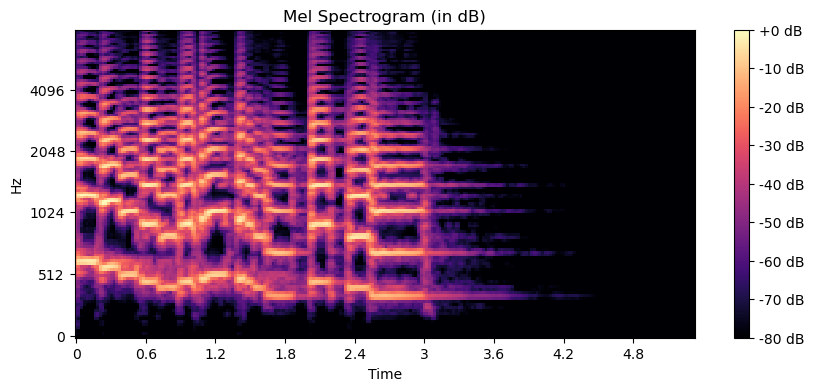

In [15]:
# Plot the original Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram (in dB)')
plt.show()

In [16]:
# Convert to tensor and add batch dimension
mel_spectrogram_tensor = tf.expand_dims(tf.convert_to_tensor(mel_spectrogram_db), -1)
mel_spectrogram_tensor = tf.repeat(mel_spectrogram_tensor, 3, axis=-1)  # Repeat to get 3 channels
mel_spectrogram_tensor = tf.expand_dims(mel_spectrogram_tensor, 0)  # Add batch dimension

In [17]:
# Check the dimensions before passing to the convert function
print(f"Mel spectrogram tensor shape: {mel_spectrogram_tensor.shape}")

Mel spectrogram tensor shape: (1, 128, 230, 3)


In [18]:
# Call the convert function
overlayed_image = melspectrogram_to_cam.convert(mel_spectrogram_tensor)

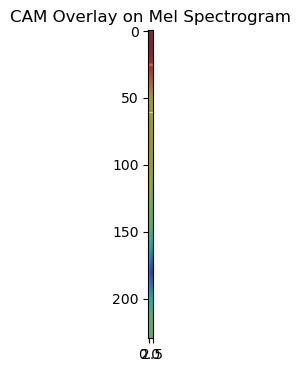

In [19]:
# Display or save the result
plt.figure(figsize=(10, 4))
plt.imshow(overlayed_image)
plt.title("CAM Overlay on Mel Spectrogram")
plt.show()

In [30]:
import numpy as np
import cv2
import torch
from PIL import Image
from torchvision import models, transforms
def main(image_path):
    #  Load a pre-trained ResNet model from torchvision and set it to evaluation mode
    model = models.resnet18(pretrained=True)
    model.eval()
    # Define image preprocessing
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),# Resize image to 224x224 pixels
        transforms.ToTensor(), # Convert image to a PyTorch tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),# Normalize with mean and std
    ])
    # Load and preprocess image
    image_path = image_path
    image = Image.open(image_path).convert('RGB') # Open and convert image to RGB
    input_tensor = preprocess(image).unsqueeze(0) # Preprocess and add a batch dimension
    # Save the features of the last convolutional layer for generating CAM
    class SaveFeatures:
        def __init__(self, module):
            self.hook = module.register_forward_hook(self.hook_fn)
        def hook_fn(self, module, input, output):
            self.features = output.data.numpy() # Save the output features as a numpy array
        def remove(self):
            self.hook.remove()# Remove the hook when done

    # Hook to the final convolutional layer of ResNet
    final_layer = model._modules.get('layer4')
    activated_features = SaveFeatures(final_layer)
    # Perform a forward pass through the model to get the predictions
    with torch.no_grad():
        output = model(input_tensor) # Get model output
        probabilities = torch.nn.functional.softmax(output[0], dim=0)

    # Get the predicted class index (the one with the highest probability)
    pred_class = probabilities.argmax().item()
    print(f'Predicted class: {pred_class}')
    # Remove the hook after getting the features
    activated_features.remove()
    # Get the predicted class index (the one with the highest probability)
    pred_class = probabilities.argmax().item()
    def get_cam(feature_conv, weight_fc, class_idx):
        _, nc, h, w = feature_conv.shape
        cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h * w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        return cam_img

    weight_softmax_params = list(model._modules.get('fc').parameters())
    weight_softmax = np.squeeze(weight_softmax_params[0].data.numpy())

    cam = get_cam(activated_features.features, weight_softmax, pred_class)
    import cv2

    mel_spectrogram_path = image_path
    mel_spectrogram = cv2.imread(mel_spectrogram_path, cv2.IMREAD_GRAYSCALE)

    # Ensure Mel spectrogram is a 3-channel image
    if len(mel_spectrogram.shape) == 2:
        mel_spectrogram = cv2.cvtColor(mel_spectrogram, cv2.COLOR_GRAY2BGR)
    # Resize CAM to match Mel spectrogram dimensions
    input_height, input_width = mel_spectrogram.shape[:2]
    cam_resized = cv2.resize(cam, (input_width, input_height))

    # Apply heatmap
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)

    # Overlay CAM on Mel spectrogram
    alpha = 0.5  # Transparency factor
    overlayed_image = cv2.addWeighted(mel_spectrogram, alpha, heatmap, 1 - alpha, 0)

    # Draw bounding box
    # Threshold CAM to find the region with significant activations
    threshold = np.max(cam_resized) * 0.5  # Adjust threshold as needed
    mask = cam_resized > threshold
    y_indices, x_indices = np.where(mask)
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    cv2.rectangle(overlayed_image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(overlayed_image, cv2.COLOR_BGR2RGB))
    plt.title(f'Predicted Class: {pred_class}')
    plt.axis('off')
    plt.show()

Predicted class: 769


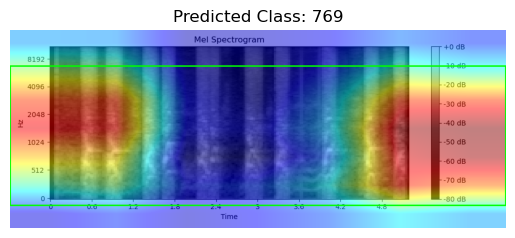

In [31]:
main('/Users/atulrane/Documents/Project Echo/Project-Echo/src/Prototypes/engine/Cam_to_mel_ar/mel_spectrogram.png')